# Reciprocal connections as a metric of complexity 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy import stats 
import pickle

In [2]:
root='/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/'
connectomes=['MICrONS', 'BBP']
base_graphs=['original', 'distance', 'ER']
data={conn:{} for conn in connectomes}
for conn in connectomes: 
    for base_graph in ['original', 'distance','ER']:
        data[conn][f'df_{base_graph}']=pd.read_pickle(f'{root}props_{conn}_{base_graph}.pkl')
        data[conn][f'df_{base_graph}_CM']=pd.read_pickle(f'{root}props_{conn}_{base_graph}_CM.pkl')

    # For additional visualization 
    for base_graph in base_graphs:
        data[conn][f'sc_{base_graph}']=pd.read_pickle(f'{root}props_{conn}_simplex_counts_{base_graph}.pkl')

    '''with open(f'{root}props_{conn}_degrees_{base_graph}.pkl', 'rb') as f:
        data[conn]['degs']=pickle.load(f)'''
    
    

# Plotting 

In [3]:
# Plotting functions 
def regress_and_plot(ax, df, base_prop, prop, scatter_kws={'alpha':0.1, 's':10}, color="C0", label_pre=''): 
    x=df[base_prop]; y=df[prop] 
    mask=np.logical_and(~np.isnan(y), ~np.isnan(x))
    regress=stats.linregress(x[mask],y[mask])
    sns.regplot(data=df, x=base_prop, y=prop, scatter_kws=scatter_kws, ax=ax, label=f'{label_pre} r: {regress.rvalue:.3f}', color=color)
    return ax
def plot_all(df, base_prop, title, color="C0"): 
    fig, axs = plt.subplots(2,3, figsize=(15,5),sharex=True)
    fig.suptitle(title)
    props = ['euclidean_edges_sc',
             'euclidean_nodes_sc',
              'cosine_sc'] # for simplices
    props+=['wasserstein_deg_total', 'wasserstein_deg_IN',
           'wasserstein_deg_OUT'] # for degrees
    for k, prop in enumerate(props):
        i=k//3;j=k%3
        axs[i,j]=regress_and_plot(axs[i,j], df, base_prop, prop, scatter_kws={'alpha':0.1, 's':10}, color=color) 
        axs[i,j].set_title(prop)
        axs[i,j].set_ylabel(prop)
        axs[i,j].legend(frameon=False)
        axs[i,j].spines[["top", "right"]].set_visible(False)
        axs[i,j].set_xlabel(base_prop)
    plt.tight_layout()

## Structural features within a graph 

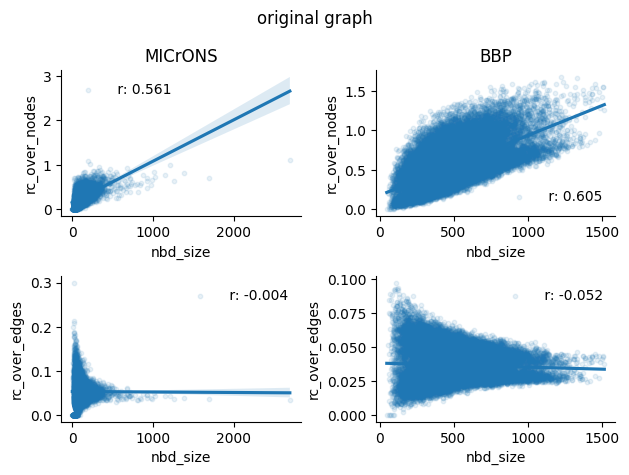

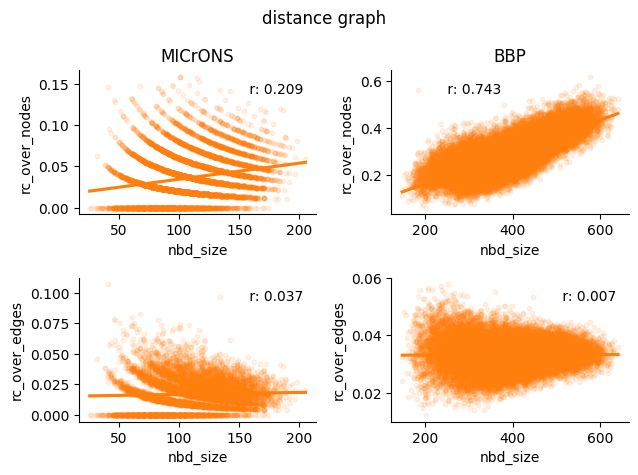

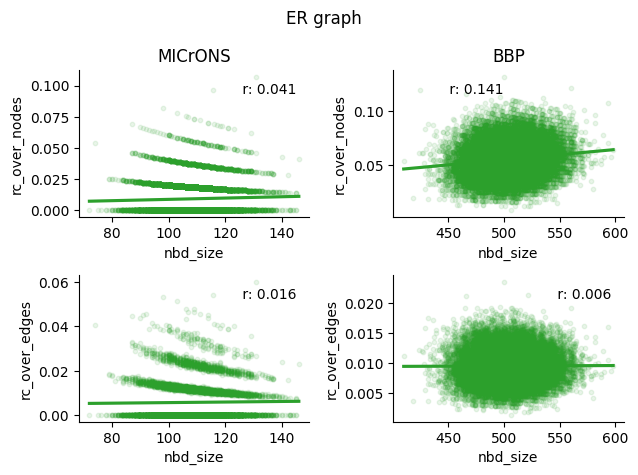

In [4]:
for k, base_graph in enumerate(base_graphs):
    fig, axs = plt.subplots(2,2)
    fig.suptitle(f'{base_graph} graph')
    for i, conn in enumerate(connectomes):
        df=data[conn][f'df_{base_graph}']
        axs[0, i].set_title(conn)
        axs[0, i]=regress_and_plot(axs[0,i], df, 'nbd_size', 'rc_over_nodes', scatter_kws={'alpha':0.1, 's':10}, color=f"C{k}")
        axs[1, i]=regress_and_plot(axs[1,i], df, 'nbd_size', 'rc_over_edges', scatter_kws={'alpha':0.1, 's':10}, color=f"C{k}")
    for ax in axs.flatten():
        ax.legend(frameon=False)
        ax.spines[["top", "right"]].set_visible(False)
    plt.tight_layout()
    fig.savefig(f'figs/rc_metrics_{base_graph}.pdf', transparent=True, bbox_inches='tight')

## Comparison with a CM control

### Overall

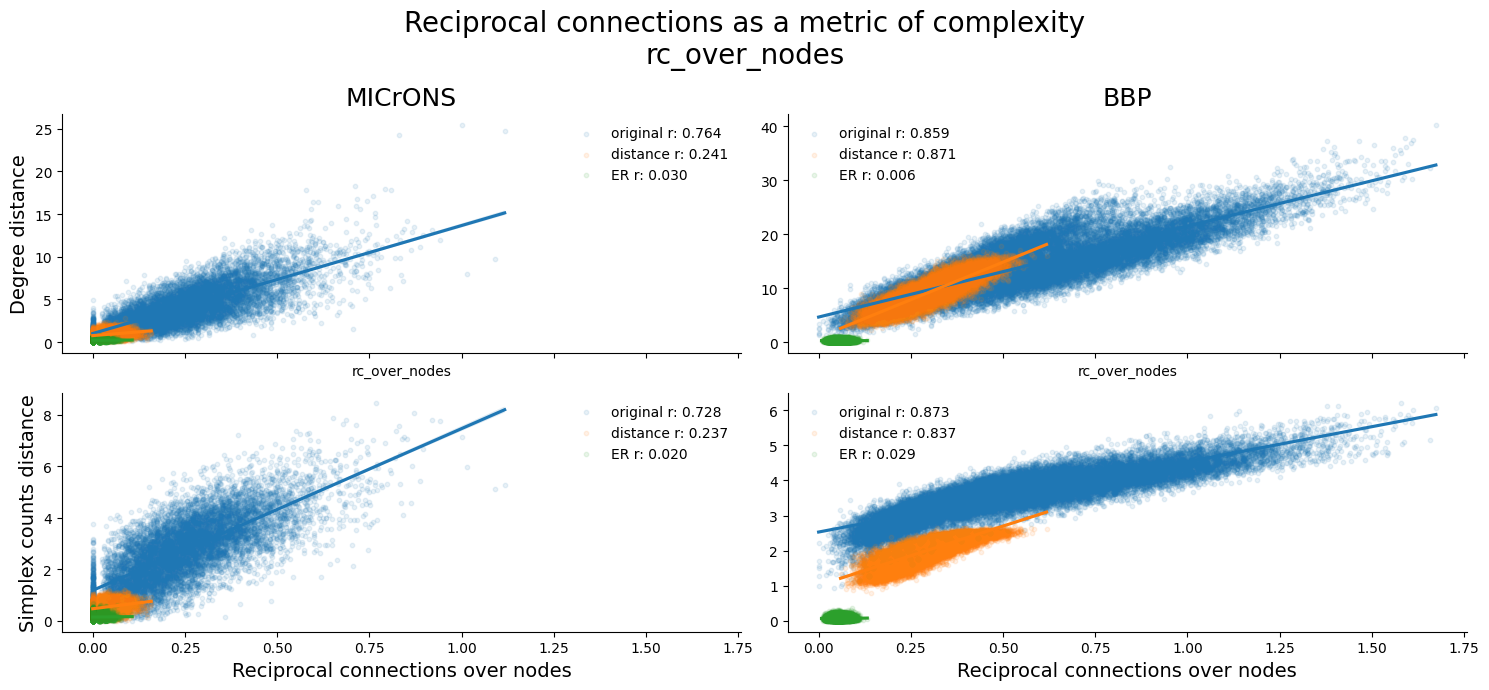

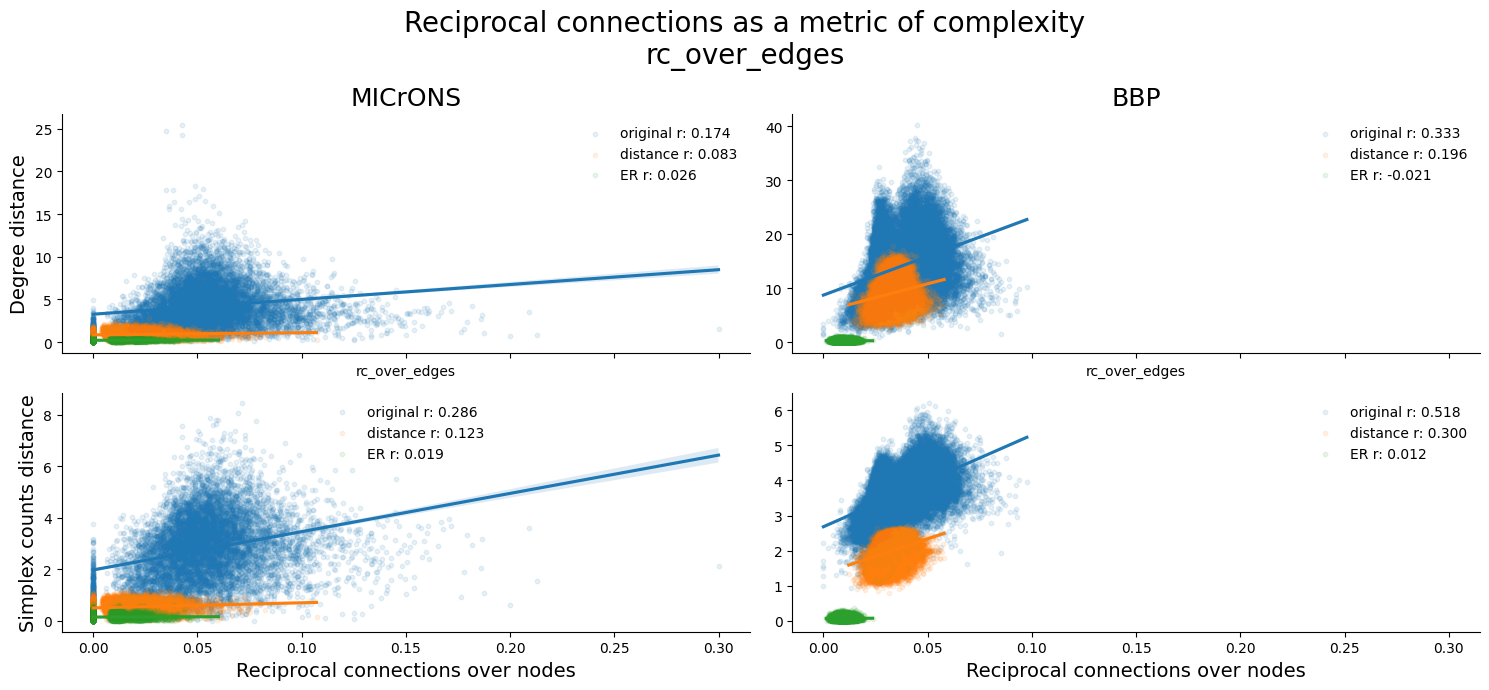

In [5]:
props = ['wasserstein_deg_total','euclidean_edges_sc'] # for degrees
props_labels = ['Degree distance','Simplex counts distance'] # for degrees
colors=["C0","C1", "C2"]

for base_prop in ['rc_over_nodes', 'rc_over_edges']:
    fig, axs = plt.subplots(2,2, figsize=(15,7),sharex=True)
    fig.suptitle(f"Reciprocal connections as a metric of complexity\n{base_prop}", fontsize=20)
    
    
    for j, conn in enumerate(connectomes):
        axs[0,j].set_title(conn, fontsize=18)
        for i, prop in enumerate(props):
            for k, base_graph in enumerate(base_graphs):
                df=data[conn][f'df_{base_graph}']
                axs[i,j]=regress_and_plot(axs[i,j], df, base_prop, prop, scatter_kws={'alpha':0.1, 's':10}, 
                                          color=colors[k], label_pre=base_graph)         
            axs[i,0].set_ylabel(props_labels[i], fontsize=14)
            axs[i,1].set_ylabel('', fontsize=14)
            axs[-1,j].set_xlabel("Reciprocal connections over nodes", fontsize=14)
            axs[i,j].legend(frameon=False)
            axs[i,j].spines[["top", "right"]].set_visible(False)
    plt.tight_layout()
    fig.savefig(f'figs/complexity_{base_prop}.pdf', transparent=True, bbox_inches='tight')

## Behaviour on outliers

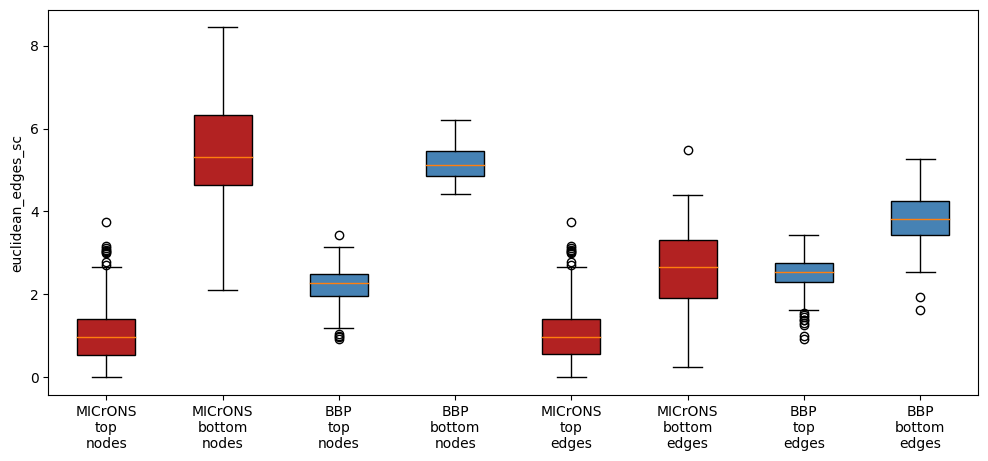

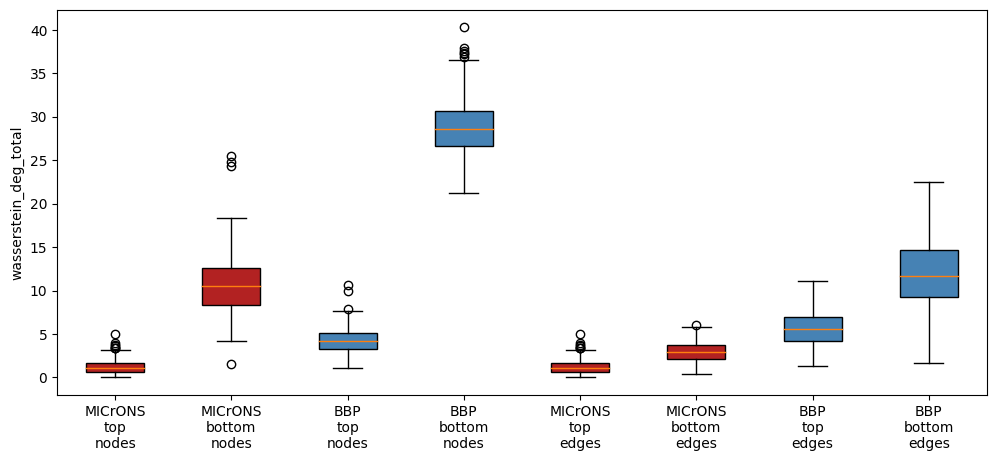

In [78]:
q=0.01; base_graph='original'; 
colors = (['firebrick']*2+['steelblue']*2)*2
for prop in ['euclidean_edges_sc', 'wasserstein_deg_total']:
    vals=[]
    labels=[]
    for base_prop in ['rc_over_nodes', 'rc_over_edges']:
        for conn in connectomes:
            df=data[conn][f'df_{base_graph}']
            top=df[df[base_prop]<=df.quantile(q)[base_prop]]
            bottom=df[df[base_prop]>df.quantile(1-q)[base_prop]]
            vals+=[top[prop],bottom[prop]]
            labels+=[f'{conn}\ntop\n{base_prop[8:]}', f'{conn}\nbottom\n{base_prop[8:]}']
    
    fig, axs = plt.subplots(figsize=(12,5))
    bplot=axs.boxplot(vals, labels=labels, patch_artist=True)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    axs.set_ylabel(prop)

# Single view of champions 

In [6]:
def get_champions(df, base_prop, n_sample=5): 
    # Indices of highes and lowest rc/nodes 
    highest=df.sort_values(by=base_prop).index[-n_sample:]
    lowest=df[df.rc_over_nodes==0].sample(n=n_sample).index
    return highest, lowest

def plot_sc(ax,counts, log=True, color="C0", markers=["o", "o"], linestyles=['solid', 'dashed'], label=None):
    for i, gtype in enumerate(['original', 'control']):
        if i>0: label=None
        ax.plot(counts.xs(gtype, level=0), marker=markers[i], color=color,
               linestyle=linestyles[i], label=label)
    if log: ax.set_yscale("log")
    return ax

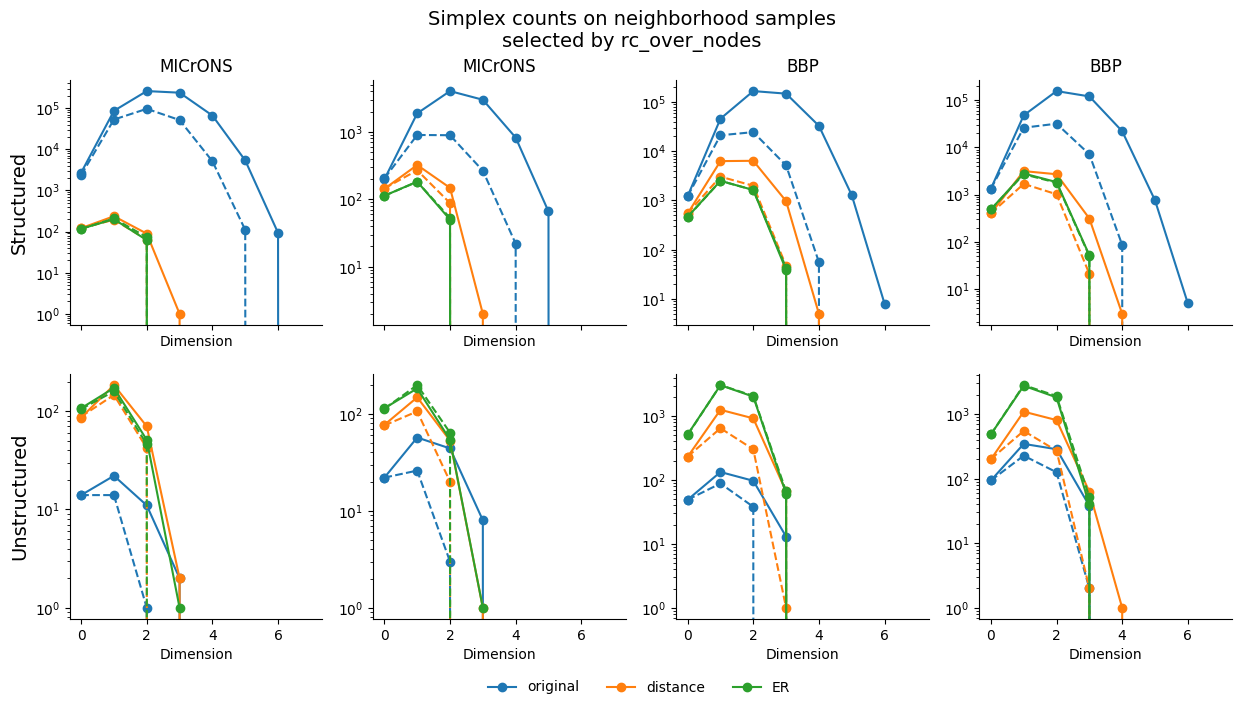

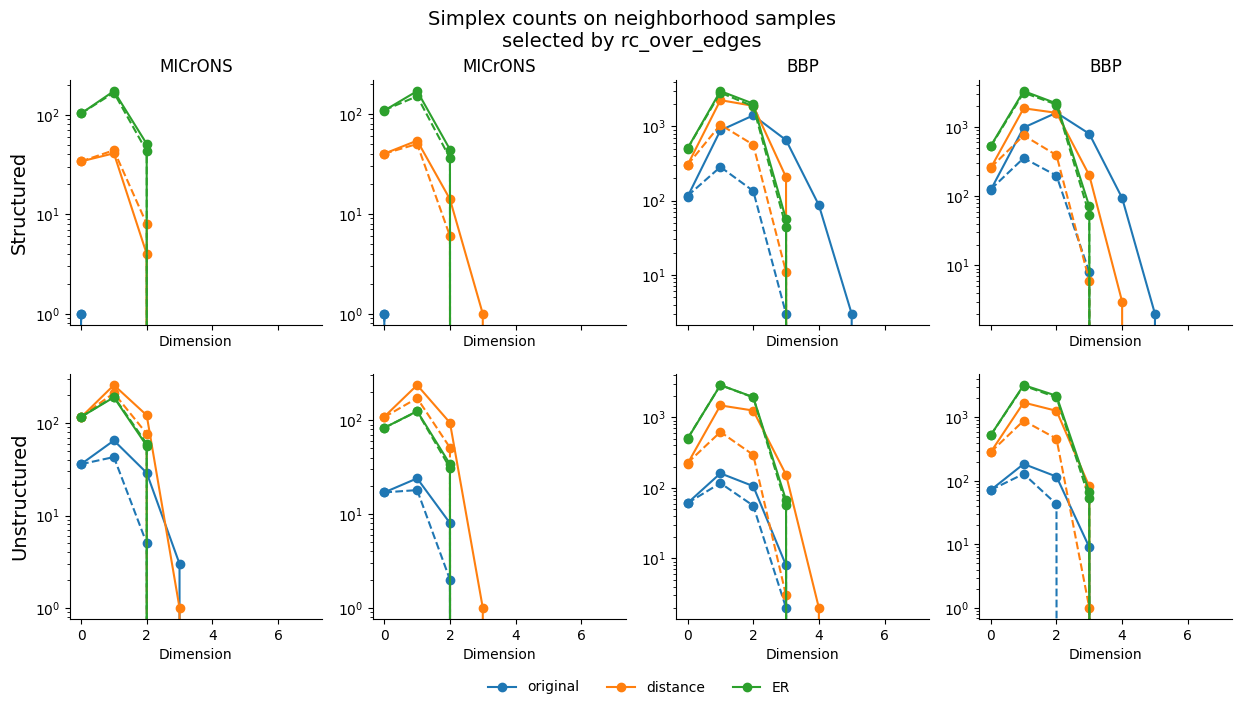

In [7]:
for base_prop in ['rc_over_nodes', 'rc_over_edges']:
    fig, axs = plt.subplots(2,4,figsize=(15,7),sharex=True)
    n_sample=5; 
    for r, conn in enumerate(connectomes): 
        # Get champions
        df=data[conn][f'df_original']
        highest, lowest=get_champions(df, base_prop, n_sample=n_sample)
        for k, base_graph in enumerate(base_graphs):
            sc_high=data[conn][f'sc_{base_graph}'].loc[highest]
            sc_low=data[conn][f'sc_{base_graph}'].loc[lowest]
            for v in range(2):
                axs[0,v+2*r].set_title(conn)
                axs[0,v+2*r]=plot_sc(axs[0,v+2*r], sc_high.iloc[n_sample-1-v], color=f"C{k}", label=base_graph, log=True)
                axs[1,v+2*r]=plot_sc(axs[1,v+2*r], sc_low.iloc[n_sample-1-v], color=f"C{k}", label=base_graph, log=True)
    axs[0,0].set_ylabel("Structured",fontsize=14) 
    axs[1,0].set_ylabel("Unstructured",fontsize=14) 
    for ax in axs.flatten():
        ax.spines[['top', 'right']].set_visible(False) 
        ax.set_xlabel("Dimension")
    
    plt.suptitle(f"Simplex counts on neighborhood samples\nselected by {base_prop}",fontsize=14)
    
    axs[-1,-1].legend(frameon=False,ncols=3,bbox_to_anchor=(-0.7,-.2))
    fig.savefig(f'figs/sc_champions_sample_by_{base_prop}.pdf', transparent=True, bbox_inches='tight')
    #plt.tight_layout()


### Split up plots of all features 

This is just to more easily see the relationships than in the scatter plots above

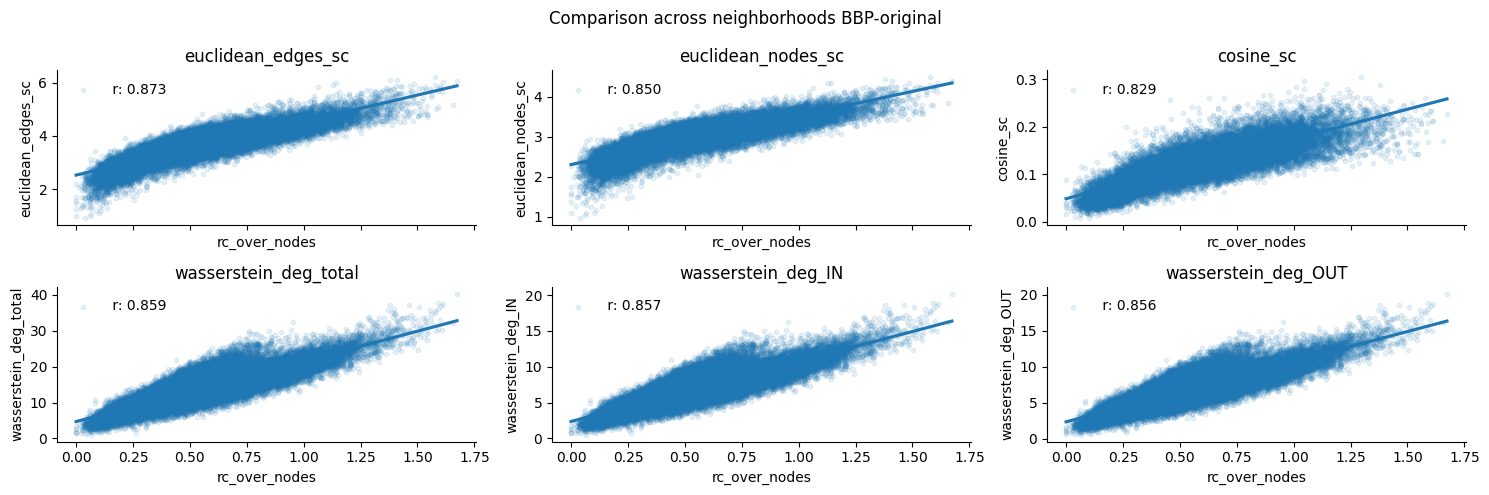

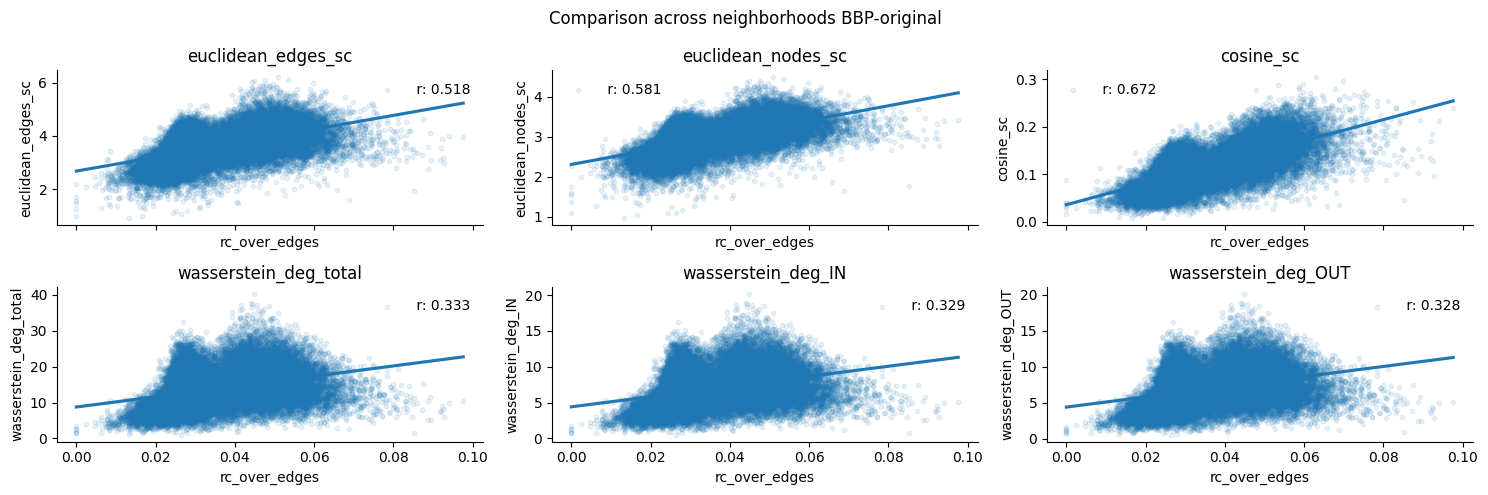

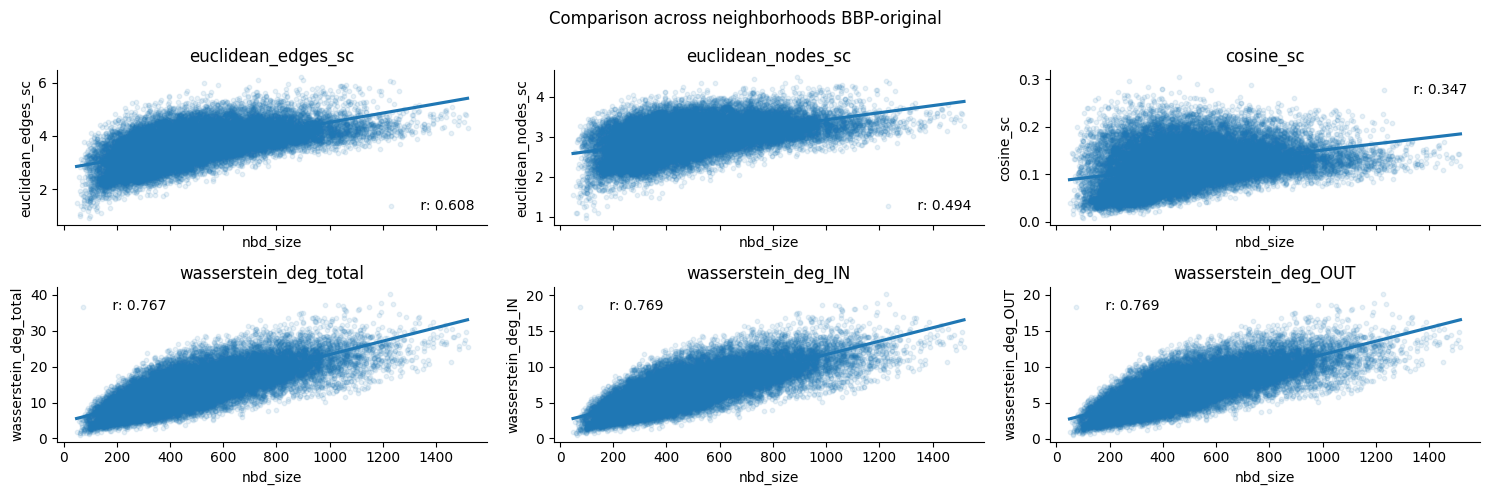

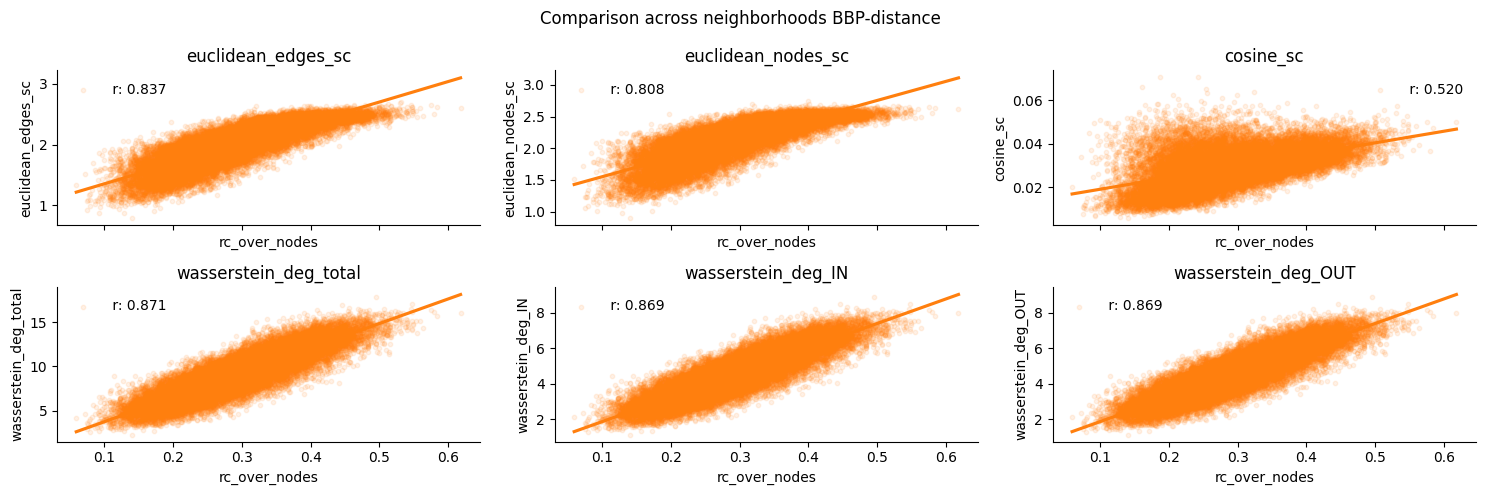

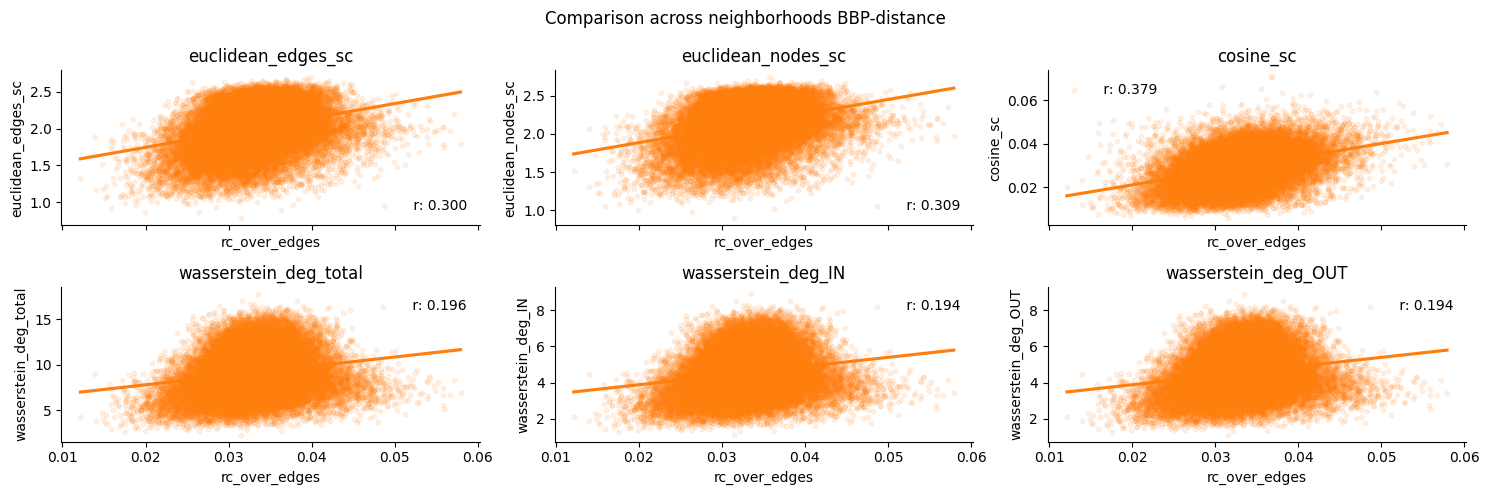

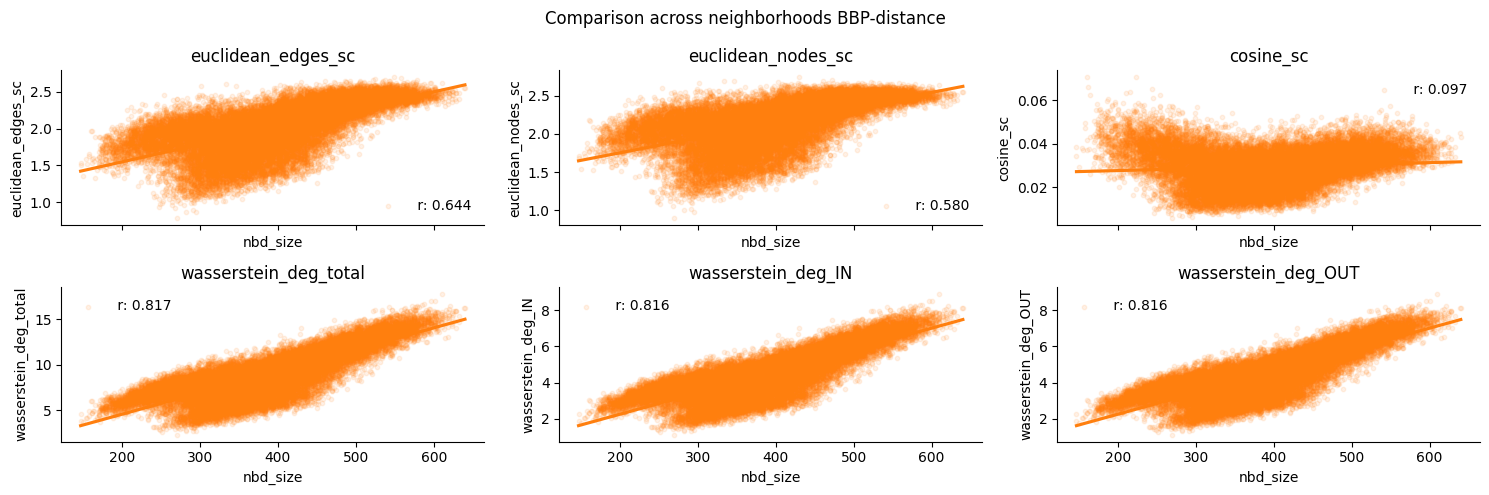

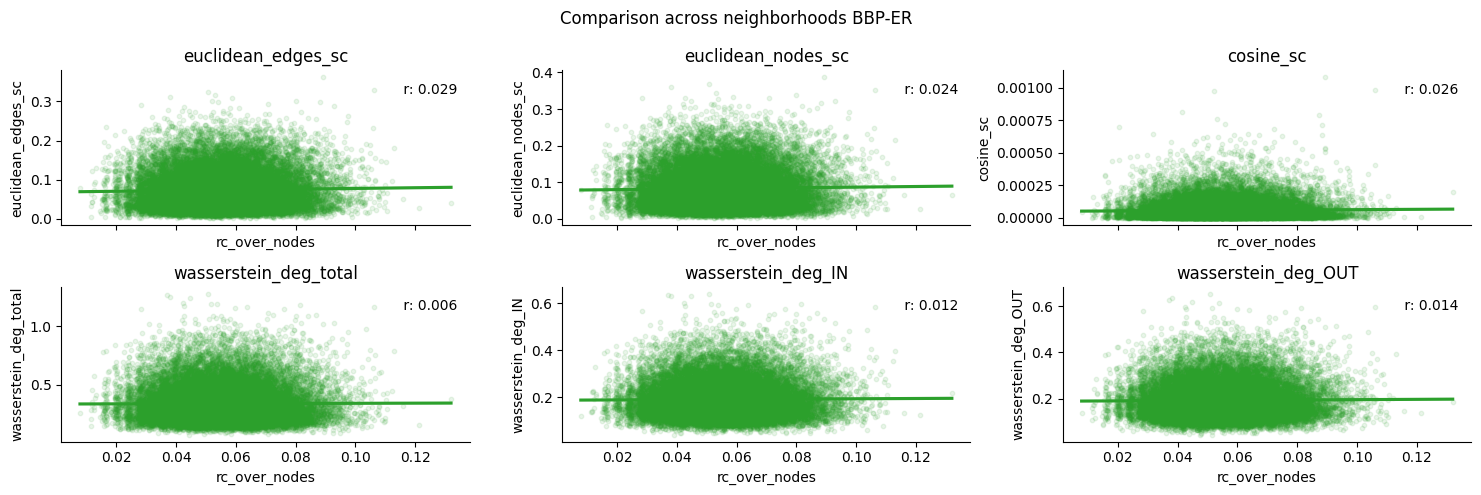

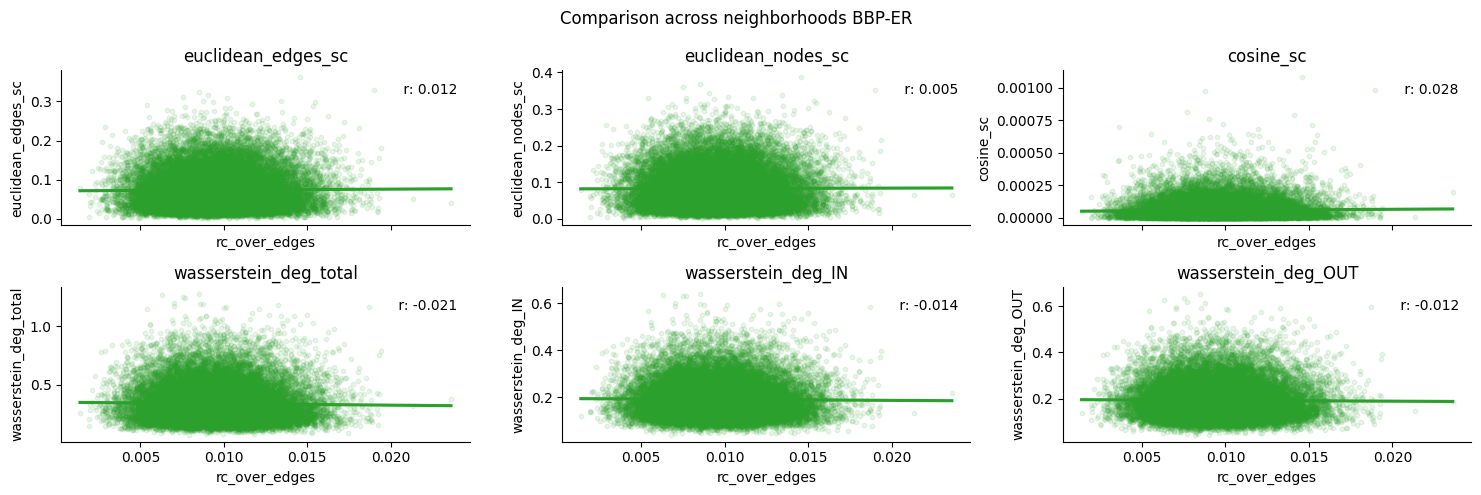

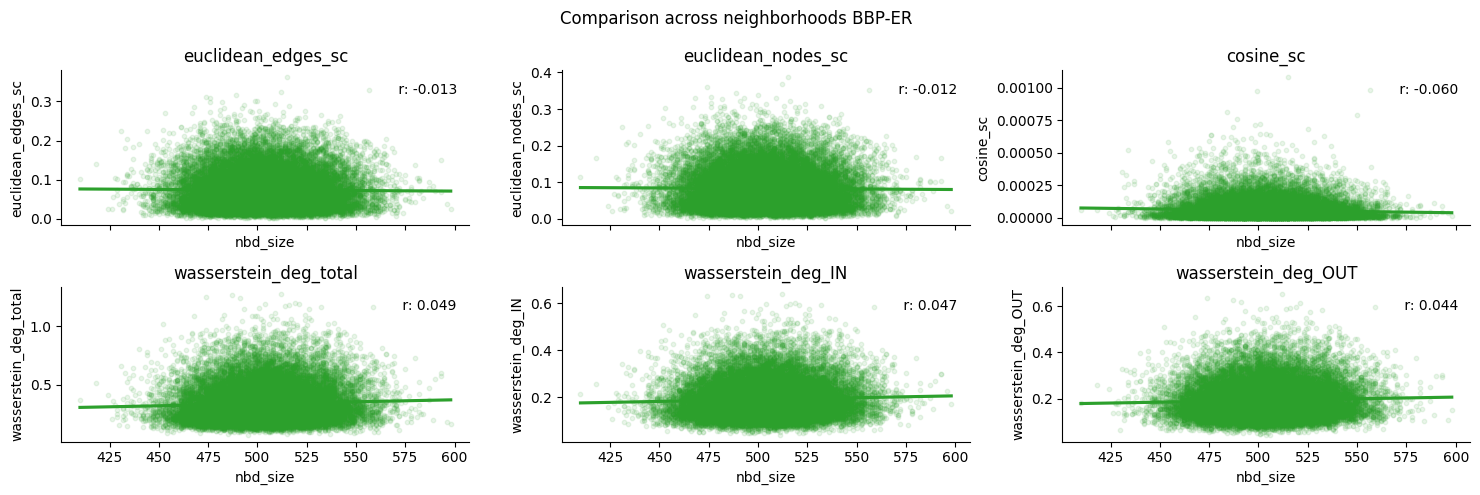

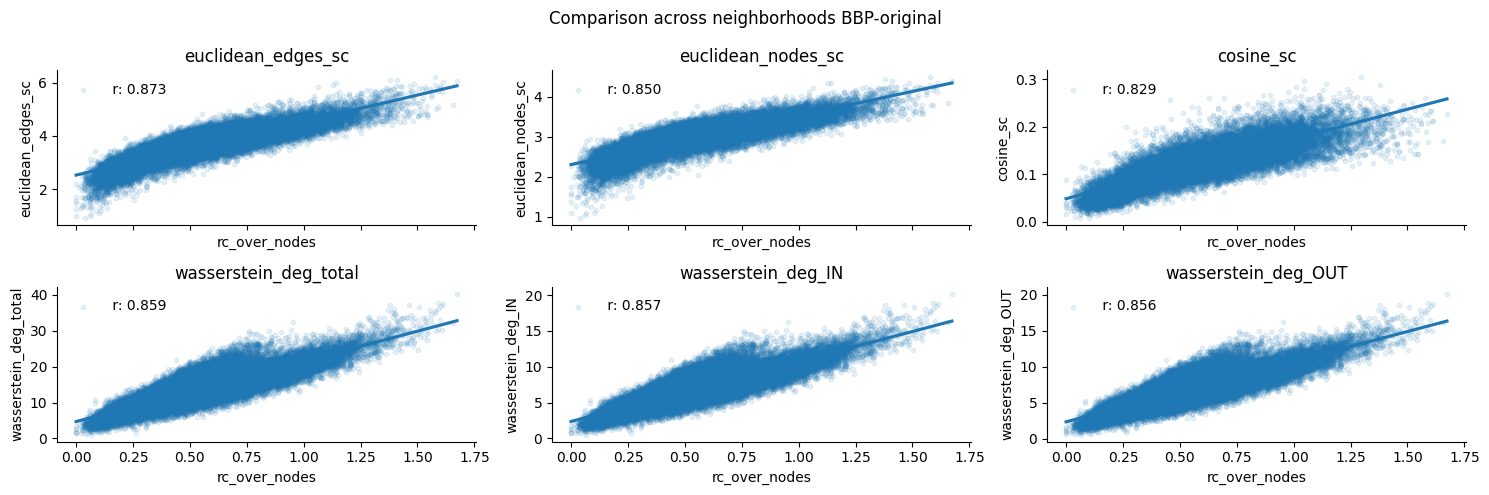

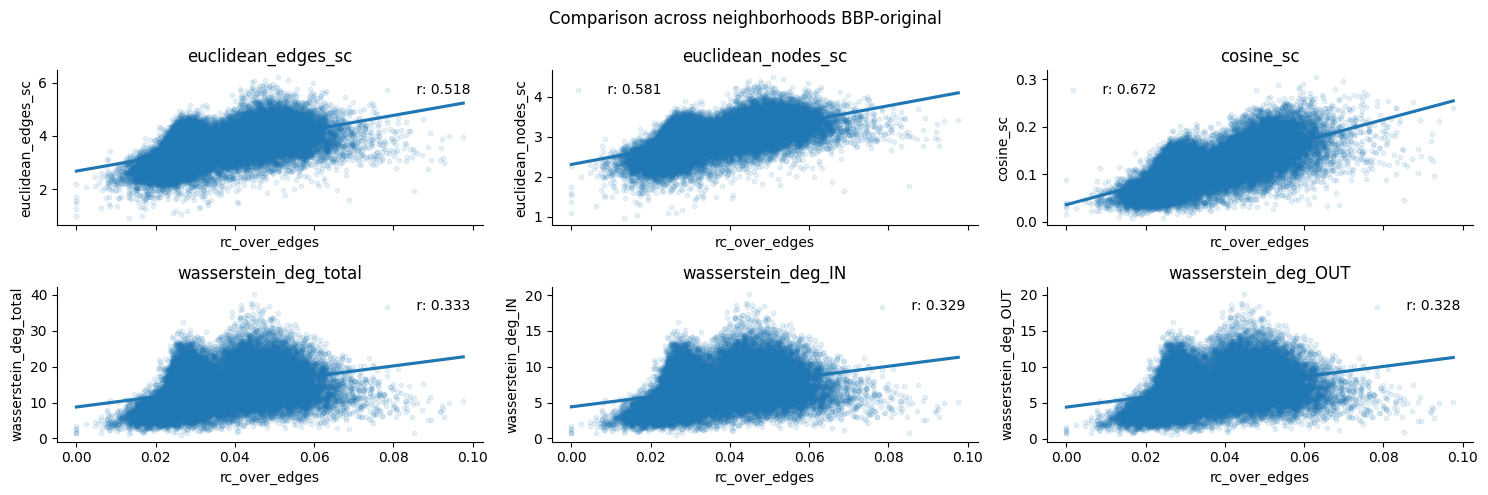

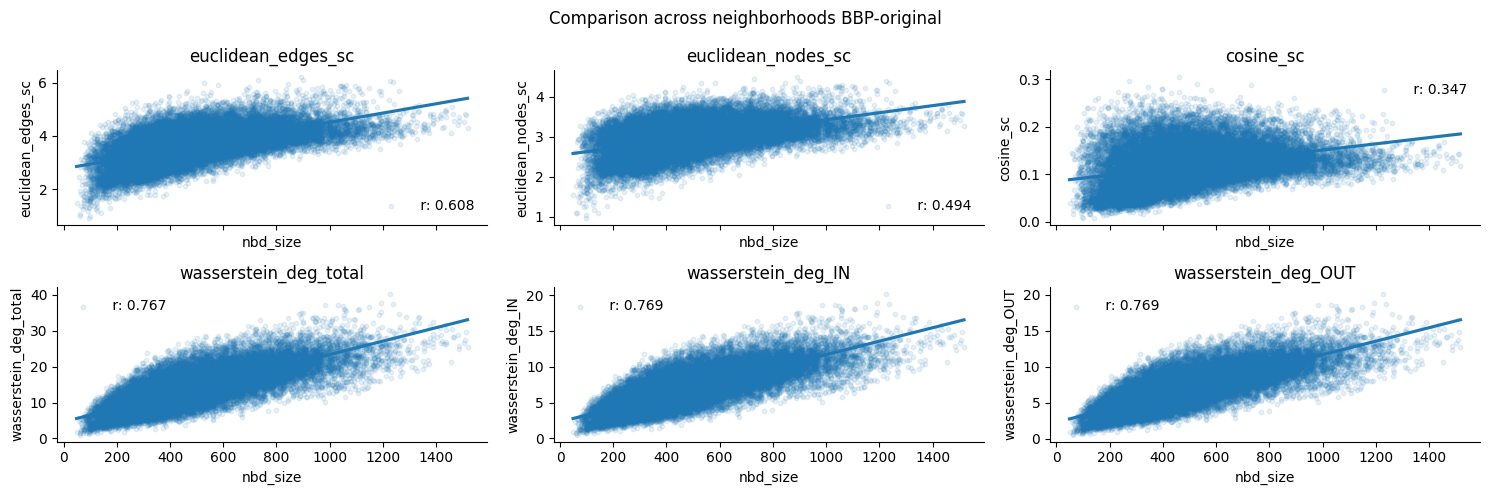

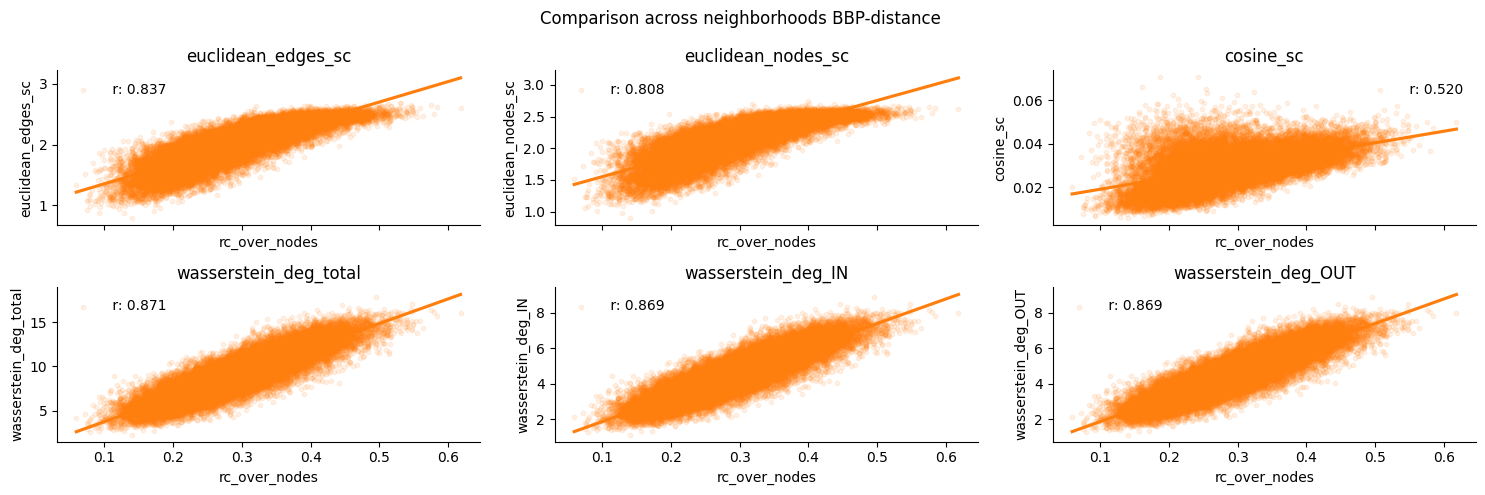

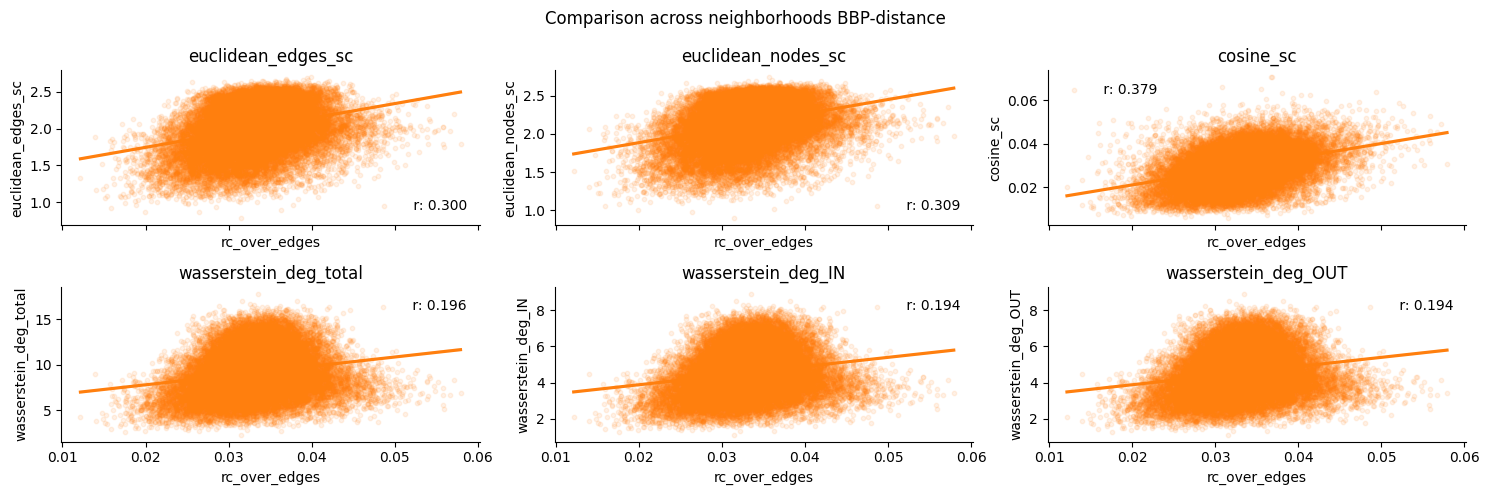

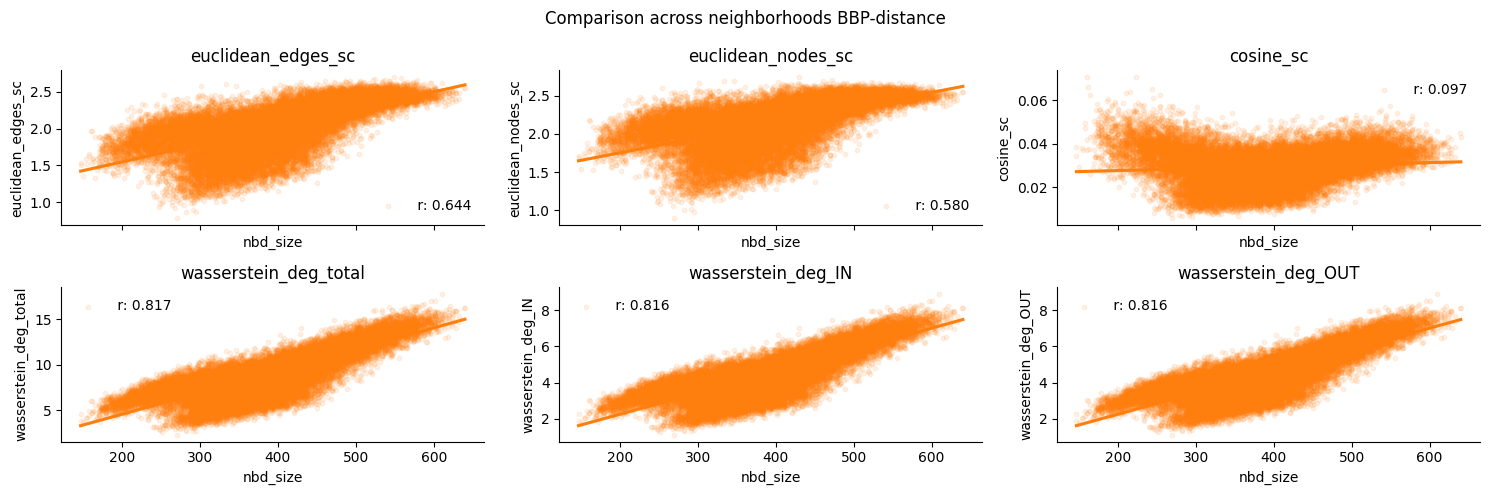

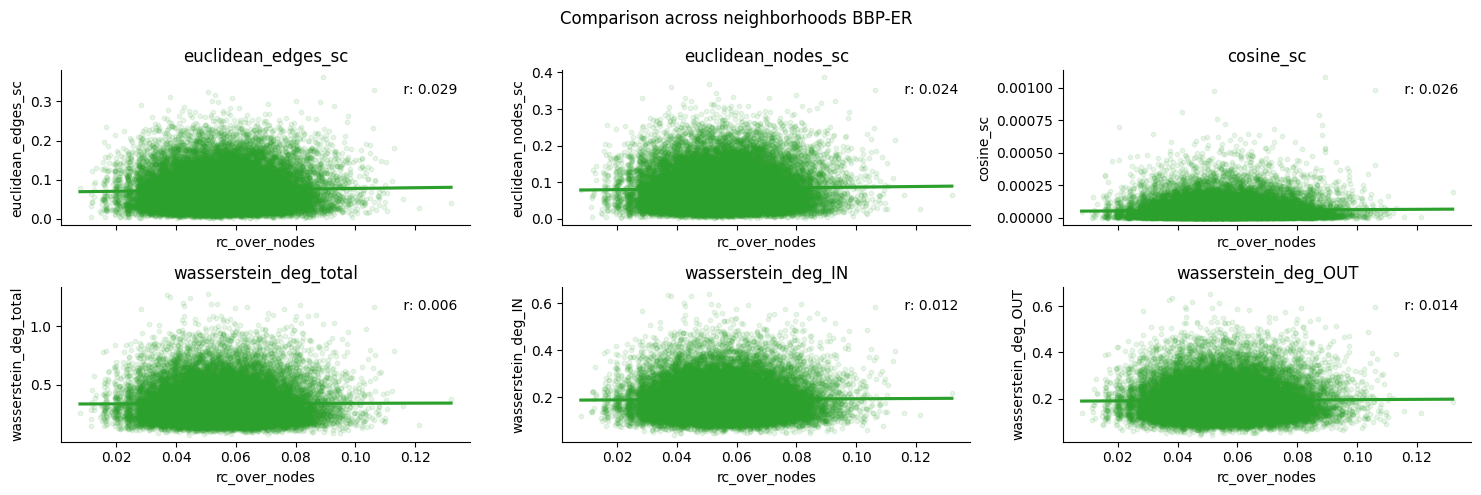

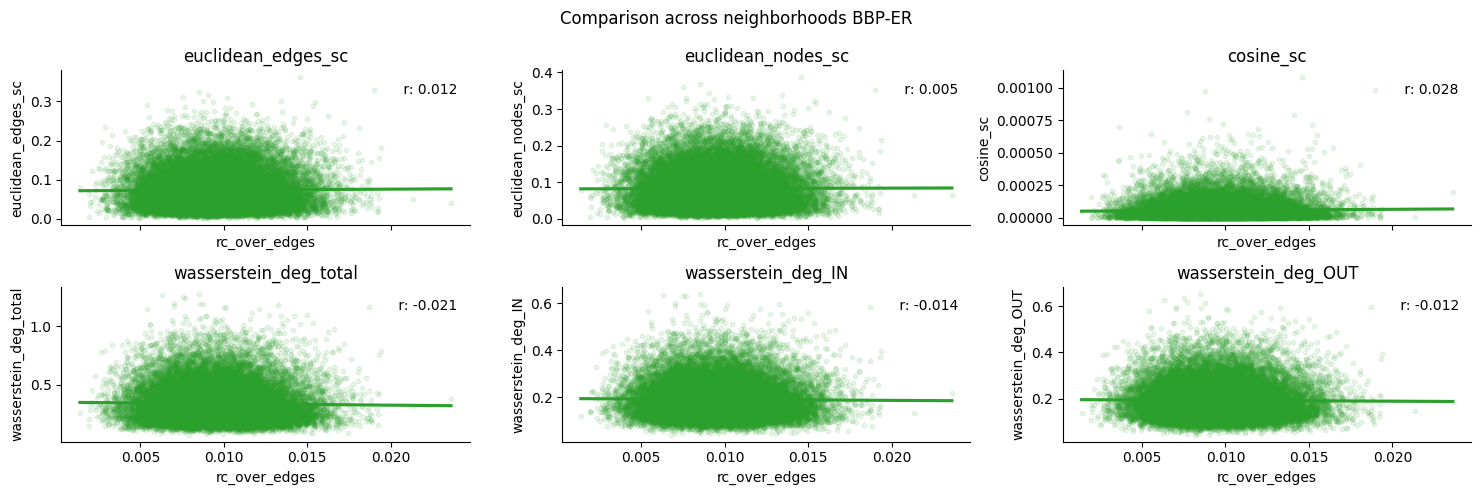

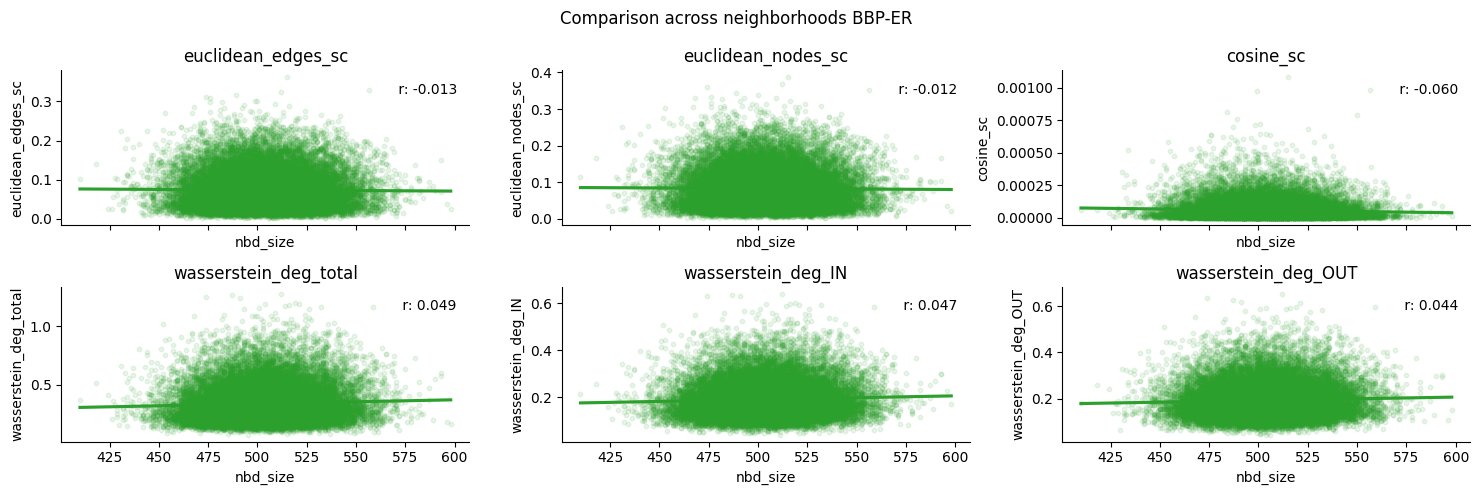

In [4]:
for con in connectomes: 
    for k, base_graph in enumerate(['original', 'distance', 'ER']):
        df=data[conn][f'df_{base_graph}']
        for base_prop in ['rc_over_nodes', 'rc_over_edges', 'nbd_size']:
            plot_all(df, base_prop, title=f'Comparison across neighborhoods {conn}-{base_graph}', color=f"C{k}")